In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
X_path = '/Users/chamathabeysinghe/Projects/monash/qr-elimination/data/qr_embeded_dataset/dataset/X'
Y_path = '/Users/chamathabeysinghe/Projects/monash/qr-elimination/data/qr_embeded_dataset/dataset/Y'
mask_path = '/Users/chamathabeysinghe/Projects/monash/qr-elimination/data/qr_embeded_dataset/dataset/masks'

data_dir = pathlib.Path(X_path)
files = [(os.path.join(X_path, item.name), os.path.join(Y_path, item.name), os.path.join(mask_path, item.name)) for item in data_dir.glob('*.png')]
list_ds = tf.data.Dataset.from_tensor_slices(files)
print(len(files))

2658


In [8]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
#       plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [128, 128])

def process_path(file_path):
    img_X = tf.io.read_file(file_path[0])
    img_X = decode_img(img_X)
    
    img_Y = tf.io.read_file(file_path[1])
    img_Y = decode_img(img_Y)
    
    img_m = tf.io.read_file(file_path[2])
    img_m = decode_img(img_m)
    
#     img_mask = tf.io.read_file(file_path[2])
#     img_mask = decode_img(img_Y)
#     return X, label
    return img_X, img_Y, img_m


def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = prepare_for_training(labeled_ds)
# image_batch, label_batch = next(iter(train_ds))
# show_batch(image_batch)


In [14]:
def completion_network():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(128, 128, 3)))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', activation='sigmoid'))
    return model
    

In [15]:
model = completion_network()

In [16]:
# model.compile(optimizer='adam', loss='mse')
# test_dataset = train_ds.take(100)
# train_dataset = train_ds.skip(100)
# model.fit(train_dataset, epochs=5, steps_per_epoch = 63, validation_data=test_dataset, validation_steps= 10)

In [21]:
# loss_object = tf.keras.losses.MeanSquaredError()
def loss_fn(target_y, predicted_y, mask):
  return tf.square(tf.math.multiply(target_y, mask) - tf.math.multiply(predicted_y, mask))
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [22]:
@tf.function
def train_step(images, labels, masks):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_fn(labels, predictions, masks)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
    
@tf.function
def test_step(images, labels, masks):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_fn(labels, predictions, masks)

  test_loss(t_loss)


In [33]:
EPOCHS = 50
TRAIN_ITERATIONS = 63
TEST_ITERATIONS = 10
test_dataset = train_ds.take(100)
train_dataset = train_ds.skip(100)

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for _ in range(TRAIN_ITERATIONS):
        images, labels, masks = next(iter(train_dataset))
        train_step(images, labels, masks)

    for _ in range(TEST_ITERATIONS):
        test_images, test_labels, test_masks = next(iter(test_dataset))
        test_step(test_images, test_labels, test_masks)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        100,
                        test_loss.result(),
                         100))

Epoch 1, Loss: 8.472905028611422e-05, Accuracy: 100, Test Loss: 7.625241414643824e-05, Test Accuracy: 100
Epoch 2, Loss: 7.333482062676921e-05, Accuracy: 100, Test Loss: 7.078736234689131e-05, Test Accuracy: 100
Epoch 3, Loss: 6.620113708777353e-05, Accuracy: 100, Test Loss: 5.298817632137798e-05, Test Accuracy: 100
Epoch 4, Loss: 5.5783293646527454e-05, Accuracy: 100, Test Loss: 4.840302062802948e-05, Test Accuracy: 100
Epoch 5, Loss: 4.933382660965435e-05, Accuracy: 100, Test Loss: 4.9774902436183766e-05, Test Accuracy: 100
Epoch 6, Loss: 4.668239489546977e-05, Accuracy: 100, Test Loss: 4.2975731048500165e-05, Test Accuracy: 100
Epoch 7, Loss: 4.1752737161004916e-05, Accuracy: 100, Test Loss: 4.0972776332637295e-05, Test Accuracy: 100
Epoch 8, Loss: 3.874088724842295e-05, Accuracy: 100, Test Loss: 3.960176763939671e-05, Test Accuracy: 100
Epoch 9, Loss: 3.734187703230418e-05, Accuracy: 100, Test Loss: 3.612221553339623e-05, Test Accuracy: 100
Epoch 10, Loss: 3.463167013251223e-05, Ac

KeyboardInterrupt: 

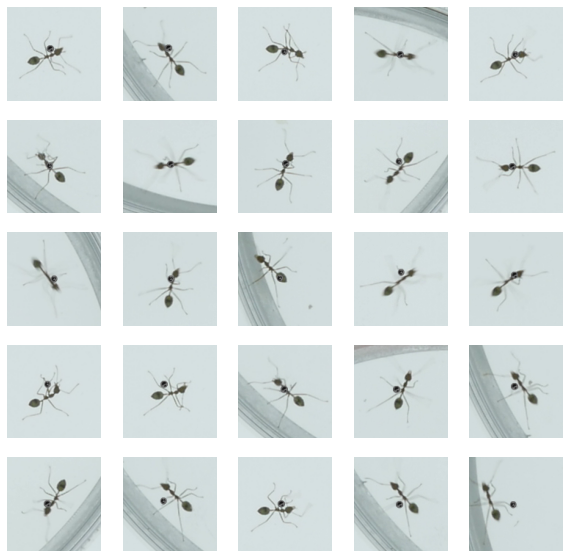

In [42]:
image_batch, label_batch, mask_batch = next(iter(test_dataset))
# show_batch(tf.math.multiply(image_batch, mask_batch))
show_batch(image_batch)

In [43]:
predictions = model.predict(image_batch)

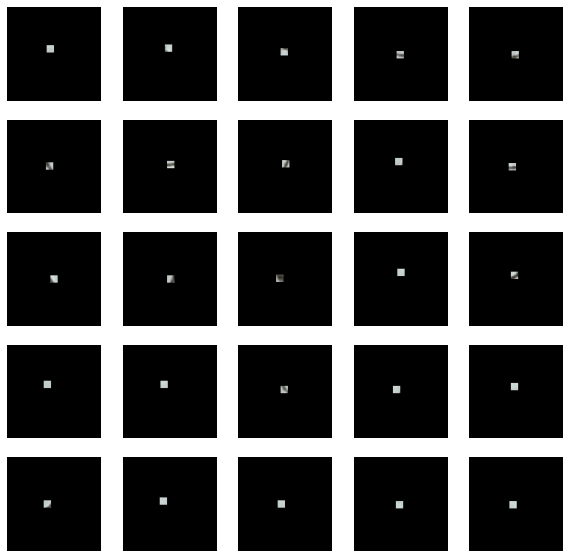

In [44]:
# show_batch(predictions)
show_batch(tf.math.multiply(predictions, mask_batch))

In [45]:
background = tf.math.multiply(image_batch, tf.math.subtract(1, mask_batch))
inpainting = tf.math.multiply(predictions, mask_batch)
completed_image = tf.math.add(background, inpainting)

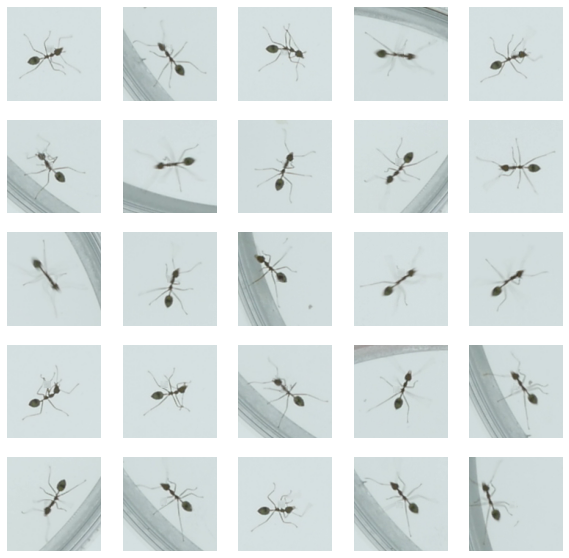

In [46]:
show_batch(completed_image)